## Imports

In [1]:
# for arrays, dataframe and visulizatiion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for http request and scraping 
import requests
from bs4 import BeautifulSoup

# to make the program pause and path
import time
import random
from pathlib import Path

## extractStockData

Takes stock price data from stocklore api and returns a pandas dataframe

**stock_code** : Nse stock code for the company

In [16]:
def extractStockData(stock_code):
    
    # reuqest to get data from api
    response = requests.get("https://www.stocklore.ai/api/nse_data.csv?q="+stock_code)
    
    # decoding the content to utf-8 and creating a list of all the lines
    a = response.content.decode("utf-8").split("\n")
    
    if(len(a)>2): # any invalid nsestock code has 2 lines
        
        # splitting each line into elements of different attributes
        a = [i.split(",") for i in a]
        
        # storing them in DataFrame, and doing necessary type convertions and sorting 
        price_df = pd.DataFrame(a[1:-1], columns=a[0])
        price_df.iloc[:,1:] = price_df.iloc[:,1:].astype('float')
        price_df['Date'] = pd.to_datetime(price_df['Date'], format='%Y-%m-%d')
        price_df = price_df.sort_values(by=['Date']).reset_index(drop=True)
        
        return price_df
    
    else:
        
        print("Wrong Stock Code!")
        exit(0)
        

## getSplitData, getBonusData

Either scrapes data from moneycontrol.com or uses stored csv file to get stock split/bonus issue data, and returns a dataframe having companies stock split/bonus issue data

**stock_code** : Nse stock code for the company <br>
**start_year** : data from this year <br>
**end_year** : data till this year <br>
**real_time_scrape** : whether to apply real-time scrapping or not <br>
**scrape_min_interval** : specifies the minimum time(in seconds) to sleep before making a new http request(_to avoid from site blocking the requests_) <br>
**split_path / bonus_path** : specifies the path to get the csv file from


In [30]:
def getSplitData(stock_code, start_year=2008, end_year=2019, real_time_scrape=True, scrape_min_interval=15, split_path=Path('')):
    
    if(real_time_scrape=True):
        
        # creating empty dataframe
        stocks_split_info = pd.DataFrame(columns = ['NseCode', 'Company', 'OldFV', 'NewFV', 'SplitDate'])
        
        # list of all the urls to scrape from
        urls = ["https://www.moneycontrol.com/stocks/marketinfo/splits/homebody.php?sel_year="+str(i) for i in range(start_year, end_year+1)]
        
        for url in urls:
            
            # multiplying minimum interval time with a range 1 to 1.5 random number to sleep
            time.sleep(scrape_min_interval*(random.uniform(1,1.5)))
            
            # http request and extracting the content
            res = requests.get(url)
            soup = BeautifulSoup(res.content,'lxml')
            
            # getting the table which has split information
            split_table = soup.find_all('table')[-2]
            split_rows = split_table.find_all('tr')
            rows_with_data = split_rows[3:len(split_rows)-3]
            
            for row in rows_with_data:
                if(row.find('a')):
                    try:
                        # another scrape to get the nse code which is not available from the split information table
                        code = BeautifulSoup(requests.get("https://www.moneycontrol.com"+row.find('a')['href']).content, 'lxml').find('div', class_="FL gry10").get_text().split('|')[1][5:].strip()
                    except:
                        # for some pages it not detectable
                        code = 'notScraping'
                        
                    # extrating data for each cell and appending them row wise    
                    company = row.find('a').get_text()
                    lst = [row.find_all('td')[i].get_text() for i in range(1,4)]
                    stocks_split_info = stocks_split_info.append({'NseCode':code,'Company':company, 'OldFV':lst[0], 'NewFV':lst[1], 'SplitDate':lst[2]}, ignore_index=True)
                    
    else:
        # reading data to dataframe from csv  
        stocks_split_info = pd.read_csv(path)
    
    #necessary 
    stocks_split_info['SplitDate'] = pd.to_datetime(stocks_split_info['SplitDate'], format='%d-%m-%Y')
    stock_split_df = stocks_split_info[stocks_split_info["NseCode"]==stock_code]
    stock_split_df = stock_split_df.sort_values(by=['SplitDate']).reset_index(drop=True)
    
    return stock_split_df


In [31]:
def getBonusData(stock_code, start_year=2008, end_year=2019, scrape_min_interval=15, real_time_scrape=True, bonus_path=Path('')):
    if(real_time_scrape=True):
        
        # creating empty dataframe
        bonus_issue_info = pd.DataFrame(columns = ['NseCode', 'Company', 'Ratio', 'AnnouncementDate', 'RecordDate', 'Ex-Bonus'])
        
        # list of all the urls to scrape from
        urls = ["https://www.moneycontrol.com/stocks/marketinfo/bonus/homebody.php?sel_year="+str(i) for i in range(start_year, end_year+1)]
        
        for url in urls:
            
            # multiplying minimum interval time with a range 1 to 1.5 random number to sleep
            time.sleep(scrape_min_interval*(random.uniform(1,1.5)))
            
            # http request and extracting the content
            res = requests.get(url)
            soup = BeautifulSoup(res.content,'lxml')
            
            # getting the table which has split information
            bonus_table = soup.find_all('table', class_="b_12 dvdtbl")[0]
            bonus_rows = bonus_table.find_all('tr')
            rows_with_data = bonus_rows[2:]
            for row in rows_with_data:
                if(row.find('a')):
                    try:
                        # another scrape to get the nse code which is not available from the split information table
                        code = BeautifulSoup(requests.get("https://www.moneycontrol.com"+row.find('a')['href']).content, 'lxml').find('div', class_="FL gry10").get_text().split('|')[1][5:].strip()
                    except:
                        # for some pages it not detectable
                        code = 'notScraping'
                    
                    # extrating data for each cell and appending them row wise 
                    company = row.find('a').get_text()
                    lst = [row.find_all('td')[i].get_text() for i in range(1,5)]
                    bonus_issue_info = bonus_issue_info.append({'NseCode': code, 'Company':company, 'Ratio':lst[0], 'AnnouncementDate':lst[1], 'RecordDate':lst[2], 'Ex-Bonus':lst[3]}, ignore_index=True)
    
    else:
        # reading data to dataframe from csv  
        stocks_split_info = pd.read_csv(path)

    # necessary type convertions and sorting                
    bonus_issue_info['Ex-Bonus'] = pd.to_datetime(bonus_issue_info['Ex-Bonus'], format='%d-%m-%Y')
    bonus_issue_df = bonus_issue_info[bonus_issue_info['NseCode']==stock_code]
    bonus_issue_df = bonus_issue_df.sort_values(by=['Ex-Bonus']).reset_index(drop=True)
    
    return bonus_issue_df       

## adjustSplit, adjustBonus

Changes the price data with the required changes to normalize the prices due to stock split and bonus

* **adjustSplit()** : divides all the prices pre-split by a factor of (OldFaceValue/NewFaceValue) for all the stock splits
* **adjustBonus()** : Multiplies all the prices pre-bonus for a bonus of a:b by a factor of (b/a+b) for all the bonus issue

In [32]:
def adjustSplit(price_df, split_df):
    
    # type conversion to int for the prices
    split_df.iloc[:,2:4] = split_df.iloc[:,2:4].astype('int')
    
    for i in range(len(split_df)):
        price_df.loc[price_df['Date']<split_df['SplitDate'][i],['Open', 'Close', 'High', 'Low', 'Volume']] /= (split_df['OldFV'][i]/split_df['NewFV'][i])
        
    return price_df

In [33]:
def adjustBonus(price_df, bonus_df):
    
    # making the split series values and elements of a list
    bonus_df['Ratio'] = [ i.split(':') for i in bonus_df['Ratio']]
    
    for i in range(len(bonus_df)):
        price_df.loc[price_df['Date']<bonus_df['Ex-Bonus'][i],['Open', 'Close', 'High', 'Low', 'Volume']] *= (int(bonus_df['Ratio'][i][1]))/(int(bonus_df['Ratio'][i][0])+int(bonus_df['Ratio'][i][1]))
    
    return price_df

## adjustStockData

Returns the normalized prices, by taking stock code as input and few other specifications

**stock_code** : Nse stock code for the company <br>
**store** : whether to store or not <br>
**filename** : csv file name <br>
**real_time_scrape** : whether to apply real-time scrapping or not <br>
**scrape_min_interval** : specifies the minimum time(in seconds) to sleep before making a new http request(_to avoid from site blocking the requests_) <br>
**split_path and bonus_path** : specifies the path to get the csv file from

In [34]:
def adjustStockData(stock_code, store=True, filename=" ", real_time_scrape=True, scrape_min_interval=15, split_path=Path(''), bonus_path=Path('')):
    
    # extracting stock price data from the stocklore api
    price_df = extractStockData(stock_code)
    
    # extarcting start and ending year from the price data to make it only look for 
    # split and bonus in the relevent time period
    start_year = price_df['Date'][0].year
    end_year = price_df['Date'][len(price_df)-1].year

    # extract split and bonus data either with real-time scrape or from a stored file 
    split_df = getSplitData(stock_code, start_year, end_year, real_time_scrape, scrape_min_interval, path)
    bonus_df = getBonusData(stock_code, start_year, end_year, real_time_scrape, scrape_min_interval, path)
    
    # normalize the price data
    price_df = adjustSplit(price_df, split_df)
    price_df = adjustBonus(price_df, bonus_df)
    
    # if
    if(store==True):
        if(filename==" "):
            price_df.to_csv(stock_code+".csv", index=False)
        else:
            price_df.to_csv(filename+".csv", index=False)
    
    return price_df


In [35]:
a = extractStockData("JISLJALEQS")

In [36]:
b = adjustStockData("JISLJALEQS", real_time_scrape=True, scrape_min_interval=15, store=True)

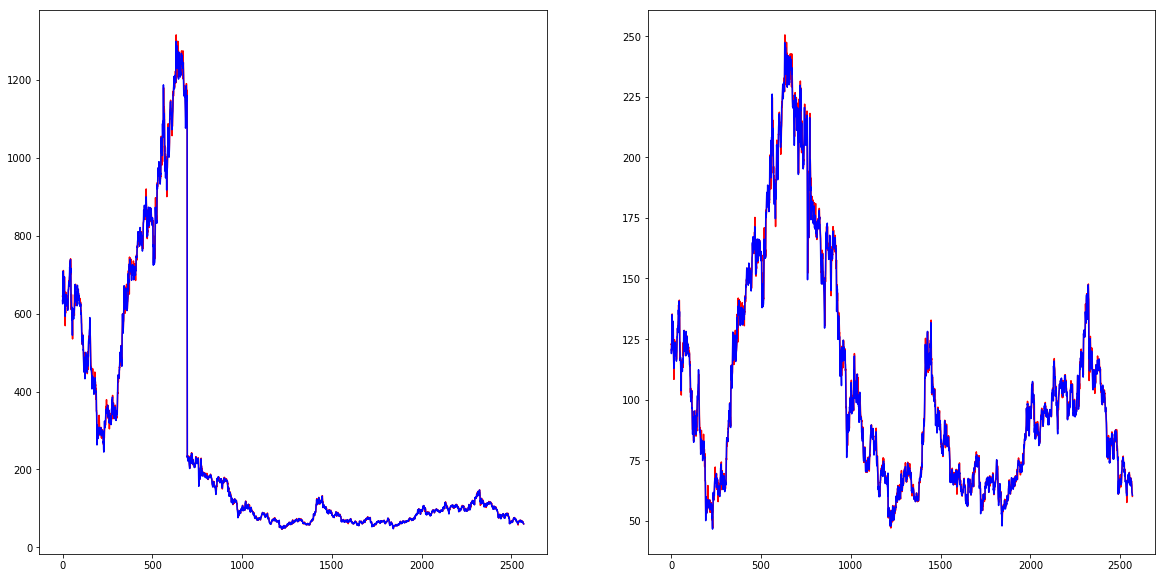

In [38]:
plt.figure(1, figsize=(20,10))
plt.subplot(121)
plt.plot(a['Open'].values, 'r-')
plt.plot(a['Close'].values, 'b-')

plt.subplot(122)
plt.plot(b['Open'].values, 'r-')
plt.plot(b['Close'].values, 'b-')

In [ ]:
#  stocks_split_info = pd.read_csv(path/"stocks_split_data_nsecode.csv")
#         stocks_split_info['SplitDate'] = pd.to_datetime(stocks_split_info['SplitDate'], format='%d-%m-%Y')
#         split_df = stocks_split_info[stocks_split_info["NseCode"]==stock_code]
#         split_df = stock_split_df.sort_values(by=['SplitDate']).reset_index(drop=True)
        
#         bonus_issue_info = pd.read_csv(path/"bonus_issue_data_nsecode.csv")
#         bonus_issue_info['Ex-Bonus'] = pd.to_datetime(bonus_issue_info['Ex-Bonus'], format='%d-%m-%Y')
#         bonus_df = bonus_issue_info[bonus_issue_info['NseCode']==stock_code]
#         bonus_df = bonus_df.sort_values(by=['Ex-Bonus']).reset_index(drop=True)